In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df  = pd.read_csv("../data/processed/dados_combinados.csv")
X = df.drop(columns=['Data', 'Eólica'])  # Features
y = df['Eólica']                          # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
modelo = ExtraTreesRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)


ExtraTreesRegressor(random_state=42)

In [13]:
y_pred = modelo.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R²: 0.8555
MAE: 25770.23
RMSE: 33645.98


R² = 0.8555 → Excelente capacidade de explicação da variabilidade dos dados.

MAE = 25.770 kWh → Erro médio absoluto relativamente baixo para valores de produção diários.

RMSE = 33.645 kWh → Penaliza mais os erros maiores, ainda assim bastante razoável.

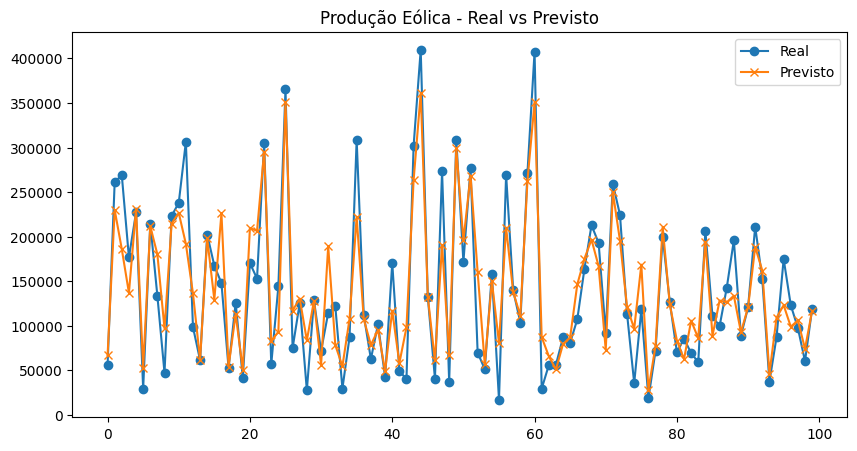

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Real', marker='o')
plt.plot(y_pred[:100], label='Previsto', marker='x')
plt.legend()
plt.title('Produção Eólica - Real vs Previsto')
plt.show()